# Computer Vision Project - Emotion Detetion using Convolutional Neural Networks
#### Context and Ojective
This project is being developed in the ambit of the Computer Vision curricular unit and it´s objective is firstly to implement a CNN, Convolutional Neural Network, capable of classifying which type of emotion a human picture is showing, and secondly we aim on being able to feed the CNN using unseen pictures and getting the correct prediction for the respective emotion shown.

#### Dataset used and description
For this project we used a widely known dataset from Kaggle, called FER-2013, which contains 48x48 pixel grayscale image of faces. The task is to categorize each face based on the emotion shown in the facial expression into one of six categories:
0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral (as shown latter we opted to remove the Disgust category because of lack of files in comparison to other categories).

This dataset is already divided in train and testing set.

#### Libraries used
Numpy, Matplotlib, seaborn, cv2, pandas, sklearn, tensorflow.




In [391]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import shutil
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, AveragePooling2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from tensorflow.keras.applications import MobileNetV2
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

## Data initial analysis
 The training set consists of 28,709 examples and the public test set consists of 3,589 examples.

In [398]:
# Path to directories
train_dir = "C:/Users/andre/Documents/Faculdade/Mestrado/1ano_1sem/VC/project/data/train/"
test_dir = "C:/Users/andre/Documents/Faculdade/Mestrado/1ano_1sem/VC/project/data/test/"

In [399]:
def count_images(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

train_counts = count_images(train_dir)
test_counts = count_images(test_dir)

print("Training images by class:", train_counts)
print("Testing images by class:", test_counts)

Training images by class: {'angry': 3995, 'fear': 4097, 'happy': 7215, 'neutral': 4965, 'sad': 4830, 'surprise': 3171}
Testing images by class: {'angry': 958, 'fear': 1024, 'happy': 1774, 'neutral': 1233, 'sad': 1247, 'surprise': 831}


In [347]:
data = {
    'Category': ['surprise', 'fear', 'angry', 'neutral', 'sad', 'happy'] * 2,
    'Count': [3171, 4097, 3995, 4965, 4830, 7215, 831, 1024, 958, 1233, 1247, 1774],
    'Dataset': ['Training'] * 6 + ['Test'] * 6
}

df = pd.DataFrame(data)

## Class distribution problem addressed
With the code bellow we can see the image distribution for each class. It is visible that the images are not equally distributed among each class. To adress this we opted on using a library called imblearn, which helps balance datasets by randomly duplicating samples from the minority classes. 

Our objective with this is to address the problem of class imbalance, which could lead to biased models that perform poorly on underrepresented classes. By balancing the dataset, the model can learn to treat all classes more equally.

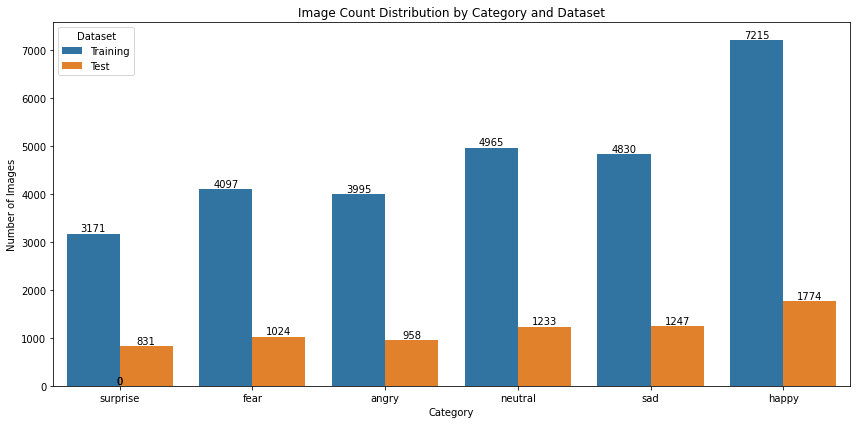

In [348]:
plt.figure(figsize=(12, 6))

ax = sns.barplot(x='Category', y='Count', hue='Dataset', data=df)

for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x = p.get_x() + width / 2
    y = p.get_y() + height
    ax.annotate(f'{int(height)}', (x, y), ha='center', va='bottom', fontsize=10)

plt.title('Image Count Distribution by Category and Dataset')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.legend(title='Dataset')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [349]:
train_counts = {
    'Category': ['surprise', 'fear', 'angry', 'neutral', 'sad', 'happy'],
    'Count': [3171, 4097, 3995, 4965, 4830, 7215]
}

test_counts = {
    'Category': ['surprise', 'fear', 'angry', 'neutral', 'sad', 'happy'],
    'Count': [831, 1024, 958, 1233, 1247, 1774]
}

df_train = pd.DataFrame(train_counts)
df_test = pd.DataFrame(test_counts)

In [350]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=1, cols=2, specs=[[{'type':'pie'}, {'type':'pie'}]])

fig.add_trace(go.Pie(
    labels=df_train['Category'],
    values=df_train['Count'],
    name='Training Dataset',
    hoverinfo='label+percent',
    title='Training Dataset Distribution'
), row=1, col=1)

fig.add_trace(go.Pie(
    labels=df_test['Category'],
    values=df_test['Count'],
    name='Test Dataset',
    hoverinfo='label+percent',
    title='Test Dataset Distribution'
), row=1, col=2)

fig.update_layout(title_text='Dataset Distribution', title_x=0.5)

fig.show()

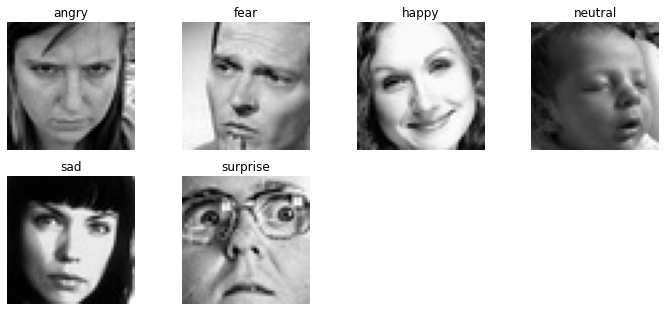

In [351]:
emotions = os.listdir(train_dir)
plt.figure(figsize=(12,8))

for i, emotion in enumerate(emotions, 1):
    folder = os.path.join(train_dir, emotion)
    img_path = os.path.join(folder, os.listdir(folder)[12])
    img = plt.imread(img_path)
    plt.subplot(3, 4, i)
    plt.grid()
    plt.imshow(img, cmap='gray')
    plt.title(emotion)
    plt.axis('off')

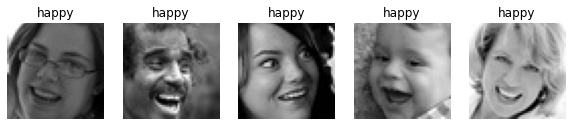

In [352]:
def show_sample_images(directory, class_name, num_samples=5):
    class_path = os.path.join(directory, class_name)
    image_files = os.listdir(class_path)[:num_samples]
    
    plt.figure(figsize=(10, 5))
    for i, img_file in enumerate(image_files):
        img_path = os.path.join(class_path, img_file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img, cmap="gray")
        plt.title(class_name)
        plt.axis("off")
    plt.show()

show_sample_images(train_dir, "happy")

In [353]:
# Check dimensions of some images
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        img_path = os.path.join(class_path, os.listdir(class_path)[0])
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        print(f"Classe: {class_name}, Dimensão: {img.shape}")
        break

Classe: angry, Dimensão: (48, 48)


In [354]:
# Check pixel values for possible normalization
img_example = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
print(f"Valores mínimos e máximos de pixel: {img_example.min()}, {img_example.max()}")

Valores mínimos e máximos de pixel: 3, 197


In [355]:
filepaths = []
labels = []

folds = os.listdir(train_dir)
for fold in folds:
    foldpath = os.path.join(train_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
train_df = pd.concat([Fseries, Lseries], axis= 1)

In [356]:
train_df

,filepaths,labels
0,C:/Users/andre/Documents/Faculdade/Mestrado/1a...,angry
1,C:/Users/andre/Documents/Faculdade/Mestrado/1a...,angry
2,C:/Users/andre/Documents/Faculdade/Mestrado/1a...,angry
3,C:/Users/andre/Documents/Faculdade/Mestrado/1a...,angry
4,C:/Users/andre/Documents/Faculdade/Mestrado/1a...,angry
...,...,...
28268,C:/Users/andre/Documents/Faculdade/Mestrado/1a...,surprise
28269,C:/Users/andre/Documents/Faculdade/Mestrado/1a...,surprise
28270,C:/Users/andre/Documents/Faculdade/Mestrado/1a...,surprise
28271,C:/Users/andre/Documents/Faculdade/Mestrado/1a...,surprise


In [357]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(train_df[['filepaths']], train_df['labels'])

balanced_train_df = pd.DataFrame({
    'filepaths': X_resampled['filepaths'],
    'labels': y_resampled
})

In [359]:
balanced_train_df['labels'].value_counts()

labels
angry       7215
fear        7215
happy       7215
neutral     7215
sad         7215
surprise    7215
Name: count, dtype: int64

In [360]:
balanced_train_df

,filepaths,labels
0,C:/Users/andre/Documents/Faculdade/Mestrado/1a...,angry
1,C:/Users/andre/Documents/Faculdade/Mestrado/1a...,angry
2,C:/Users/andre/Documents/Faculdade/Mestrado/1a...,angry
3,C:/Users/andre/Documents/Faculdade/Mestrado/1a...,angry
4,C:/Users/andre/Documents/Faculdade/Mestrado/1a...,angry
...,...,...
43285,C:/Users/andre/Documents/Faculdade/Mestrado/1a...,surprise
43286,C:/Users/andre/Documents/Faculdade/Mestrado/1a...,surprise
43287,C:/Users/andre/Documents/Faculdade/Mestrado/1a...,surprise
43288,C:/Users/andre/Documents/Faculdade/Mestrado/1a...,surprise


In [361]:
filepaths = []
labels = []

folds = os.listdir(test_dir)
for fold in folds:
    foldpath = os.path.join(test_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
ts_df = pd.concat([Fseries, Lseries], axis= 1)

In [363]:
ts_df

,filepaths,labels
0,C:/Users/andre/Documents/Faculdade/Mestrado/1a...,angry
1,C:/Users/andre/Documents/Faculdade/Mestrado/1a...,angry
2,C:/Users/andre/Documents/Faculdade/Mestrado/1a...,angry
3,C:/Users/andre/Documents/Faculdade/Mestrado/1a...,angry
4,C:/Users/andre/Documents/Faculdade/Mestrado/1a...,angry
...,...,...
7062,C:/Users/andre/Documents/Faculdade/Mestrado/1a...,surprise
7063,C:/Users/andre/Documents/Faculdade/Mestrado/1a...,surprise
7064,C:/Users/andre/Documents/Faculdade/Mestrado/1a...,surprise
7065,C:/Users/andre/Documents/Faculdade/Mestrado/1a...,surprise


As seen bellow, we also repeated the process for both the training and testing sets, in order to have both balanced sets.

In [366]:
ros = RandomOverSampler(random_state=42)
X_resampled_ts, y_resampled_ts = ros.fit_resample(ts_df[['filepaths']], ts_df['labels'])

balanced_ts_df = pd.DataFrame({
    'filepaths': X_resampled_ts['filepaths'],
    'labels': y_resampled_ts
})

In [367]:
balanced_ts_df['labels'].value_counts()

labels
angry       1774
fear        1774
happy       1774
neutral     1774
sad         1774
surprise    1774
Name: count, dtype: int64

Now, the code bellow is preparing the image datasets for training, validation, and testing.
 It employs two approaches for handling image data: one using the flow_from_directory method and the other using flow_from_dataframe. The goal is to create pipelines for loading, augmenting, and preprocessing images for model input.

In the first part, data augmentation and preprocessing are set up for training and validation datasets using ImageDataGenerator. For training, random transformations such as shifting and horizontal flipping are applied to increase dataset diversity and improve model generalization. Both training and validation data are normalized by rescaling pixel values to the range [0, 1]. Images are loaded from directories (train_dir and test_dir), resized to 48x48 pixels, and processed in grayscale. A batch_size of 64 specifies that 64 images will be loaded and fed to the model at a time. The training dataset is further split into 80% training and 20% validation using the validation_split parameter.

The second part of the code uses flow_from_dataframe to load images and labels specified in DataFrames (train_df_new, valid_df_new, and test_df_new). This approach is more flexible, allowing image file paths and labels to be managed in tabular format. The x_col and y_col parameters define the column names for file paths and labels, respectively. Images are resized to a target size of 224x224 pixels and processed as grayscale. The class_mode is set to 'sparse', meaning labels are integers rather than one-hot encoded, which is more efficient for certain tasks.

Three datasets are prepared in this section: the training set (train_gen_new), validation set (valid_gen_new), and test set (test_gen_new). Training and validation sets are shuffled to improve learning, while the test set is not shuffled to preserve its order for evaluation. All datasets are batched with a batch_size of 16, meaning smaller batches are used compared to the first part.

In [369]:
train_datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    rescale=1./255,
    validation_split=0.2
)

validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(48, 48),
    batch_size=64,
    color_mode='grayscale',
    class_mode='categorical',
    subset='training'
)

validation_generator = validation_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(48, 48),
    batch_size=64,
    color_mode='grayscale',
    class_mode='categorical',
    subset='validation'
)

class_names = list(train_generator.class_indices.keys())

Found 22619 images belonging to 6 classes.
Found 1410 images belonging to 6 classes.


In [380]:
train_df_new, temp_df_new = train_test_split(
    balanced_train_df,
    train_size=0.8,  
    shuffle=True,
    random_state=42,
    stratify=balanced_train_df['labels']  
)

valid_df_new, test_df_new = train_test_split(
    temp_df_new,
    test_size=0.5,  
    shuffle=True,
    random_state=42,
    stratify=temp_df_new['labels'] 
)

In [381]:
batch_size = 16
img_size = (224, 224)
channels = 1
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen_new = tr_gen.flow_from_dataframe(train_df_new, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'sparse',
                                    color_mode= 'grayscale', shuffle= True, batch_size= batch_size)

valid_gen_new = ts_gen.flow_from_dataframe(valid_df_new, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'sparse',
                                     color_mode= 'grayscale', shuffle= True, batch_size= batch_size)

test_gen_new = ts_gen.flow_from_dataframe(test_df_new, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'sparse',
                                    color_mode= 'grayscale', shuffle= False, batch_size= batch_size)

Found 34632 validated image filenames belonging to 6 classes.
Found 4329 validated image filenames belonging to 6 classes.
Found 4329 validated image filenames belonging to 6 classes.


## Model creation

#### How a CNN works?

A Convolutional Neural Network (CNN) is a deep learning model designed to process image data by mimicking how humans perceive visual information. It uses convolutional layers with filters (kernels) to extract features like edges and textures, followed by pooling layers to reduce spatial dimensions and make the model robust to small transformations. Non-linear activation functions, like ReLU, introduce complexity, enabling the model to learn intricate patterns. These layers are stacked hierarchically, with early layers capturing simple features and deeper layers identifying complex structures. Finally, fully connected layers combine these features for tasks like classification or regression, with training optimized through backpropagation and gradient descent. CNNs are efficient and highly effective for image recognition.



#### Our Implementation

For the model creation we implemented code that defines a CNN with integrated attention mechanisms, designed for image classification tasks with seven output classes. The network begins with an input layer for grayscale images of shape (224, 224, 1), followed by multiple convolutional layers using (3, 3) filters to extract hierarchical features, with batch normalization and max pooling to stabilize and downsample these features. Two advanced attention mechanisms, Squeeze-and-Excitation (SE) blocks and Channel Attention Mechanism (CAM) blocks, are interspersed in the architecture to refine the feature maps by focusing on important channels. The SE blocks use global average pooling and fully connected layers to scale channel-wise features, while CAM blocks employ both global average and max pooling to enhance channel representations further. After feature extraction, the network flattens the output and passes it through several dense layers that progressively refine the learned representations. The final output layer with seven neurons and a softmax activation produces probabilities for classification. This architecture balances feature extraction, attention mechanisms, and dense feature refinement to create a robust model capable of precise image classification.

In [385]:
import tensorflow as tf
from tensorflow.keras import layers, Model

class SEBlock(layers.Layer):
    def __init__(self, channels, reduction_ratio=16):
        super(SEBlock, self).__init__()
        self.squeeze = layers.GlobalAveragePooling2D()
        self.fc1 = layers.Dense(channels // reduction_ratio, activation='relu')
        self.fc2 = layers.Dense(channels, activation='sigmoid')

    def call(self, inputs):
        se = self.squeeze(inputs)
        se = self.fc1(se)
        se = self.fc2(se)
        se = tf.reshape(se, [-1, 1, 1, tf.shape(inputs)[-1]])  
        return inputs * se

class CAMBlock(layers.Layer):
    def __init__(self, channels, reduction_ratio=16):
        super(CAMBlock, self).__init__()
        self.channels = channels
        self.global_avg_pool = layers.GlobalAveragePooling2D()
        self.global_max_pool = layers.GlobalMaxPooling2D()
        self.dense1 = layers.Dense(channels // reduction_ratio, activation='relu')
        self.dense2 = layers.Dense(channels, activation='sigmoid')

    def call(self, inputs):
        avg_pool = self.global_avg_pool(inputs)
        max_pool = self.global_max_pool(inputs)
        avg_out = self.dense2(self.dense1(avg_pool))
        max_out = self.dense2(self.dense1(max_pool))
        out = avg_out + max_out
        out = tf.reshape(out, [-1, 1, 1, self.channels])
        return inputs * out

img_size = (224, 224)
channels = 1
img_shape = (img_size[0], img_size[1], channels)

inputs = layers.Input(shape=img_shape)

x = layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu", padding='same')(inputs)
x = layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu", padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding='same')(x)
x = layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

x = SEBlock(128)(x)
x = CAMBlock(128)(x)

x = layers.Conv2D(filters=256, kernel_size=(3, 3), activation="relu", padding='same')(x)
x = layers.Conv2D(filters=256, kernel_size=(3, 3), activation="relu", padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(filters=512, kernel_size=(3, 3), activation="relu", padding='same')(x)
x = layers.Conv2D(filters=512, kernel_size=(3, 3), activation="relu", padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

x = SEBlock(512)(x)
x = CAMBlock(512)(x)

x = layers.Flatten()(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
outputs = layers.Dense(7, activation="softmax")(x)  

model2 = Model(inputs=inputs, outputs=outputs)

model2.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d_102 (Conv2D)         (None, 224, 224, 64)      640       
                                                                 
 conv2d_103 (Conv2D)         (None, 224, 224, 64)      36928     
                                                                 
 batch_normalization_94 (Ba  (None, 224, 224, 64)      256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_72 (MaxPooli  (None, 112, 112, 64)      0         
 ng2D)                                                           
                                                                 
 conv2d_104 (Conv2D)         (None, 112, 112, 128)     7385

In [386]:
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

## Model testing
With the code bellow, we aim to train the model2 neural network for 10 epochs using the train_gen_new dataset for training and valid_gen_new for validation. The fit method iteratively adjusts the model's parameters to minimize the loss function, using backpropagation and gradient descent. 
The epochs=10 parameter specifies that the entire dataset will be passed through the model 10 times, and verbose=1 ensures that detailed progress information is displayed during training. 
The validation_data argument evaluates the model on unseen validation data at each epoch, providing metrics to monitor performance and detect overfitting. 
The shuffle=False argument ensures the data order remains unchanged between epochs.



In [387]:
epochs = 10
history = model2.fit(train_gen_new, epochs=epochs, verbose=1, validation_data=valid_gen_new, shuffle=False)

Epoch 1/10
2165/2165 [==============================] - 11353s 5s/step - loss: 1.5870 - accuracy: 0.3548 - val_loss: 1.4839 - val_accuracy: 0.4063
Epoch 2/10
2165/2165 [==============================] - 11232s 5s/step - loss: 1.2139 - accuracy: 0.5348 - val_loss: 1.3073 - val_accuracy: 0.5094
Epoch 3/10
2165/2165 [==============================] - 11174s 5s/step - loss: 0.7759 - accuracy: 0.7247 - val_loss: 0.9413 - val_accuracy: 0.6824
Epoch 4/10
2165/2165 [==============================] - 11072s 5s/step - loss: 0.4034 - accuracy: 0.8663 - val_loss: 1.1579 - val_accuracy: 0.6466
Epoch 5/10
2165/2165 [==============================] - 11083s 5s/step - loss: 0.2328 - accuracy: 0.9269 - val_loss: 1.0183 - val_accuracy: 0.7593
Epoch 6/10
2165/2165 [==============================] - 11104s 5s/step - loss: 0.1534 - accuracy: 0.9541 - val_loss: 0.9576 - val_accuracy: 0.7713
Epoch 7/10
2165/2165 [==============================] - 11291s 5s/step - loss: 0.1175 - accuracy: 0.9652 - val_loss: 1

## Avaliação do modelo

In [388]:
loss, accuracy = model2.evaluate(test_gen_new)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

271/271 [==============================] - 430s 2s/step - loss: 1.2519 - accuracy: 0.7741
Test Accuracy: 77.41%


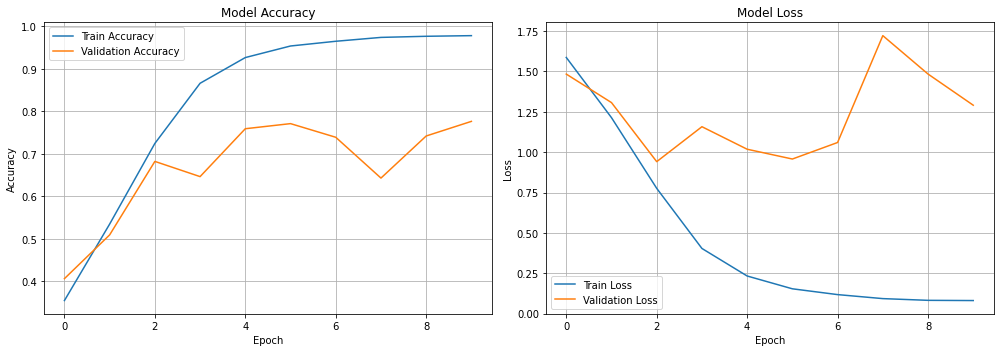

In [389]:
def plot_training_history(history):
    
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

271/271 [==============================] - 695s 3s/step


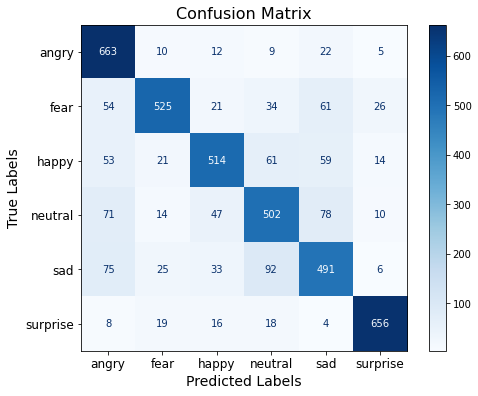

              precision    recall  f1-score   support

       angry       0.72      0.92      0.81       721
        fear       0.86      0.73      0.79       721
       happy       0.80      0.71      0.75       722
     neutral       0.70      0.70      0.70       722
         sad       0.69      0.68      0.68       722
    surprise       0.91      0.91      0.91       721

    accuracy                           0.77      4329
   macro avg       0.78      0.77      0.77      4329
weighted avg       0.78      0.77      0.77      4329



In [395]:
true_labels = test_gen_new.classes
predicted_labels = model2.predict(test_gen_new)
predicted_labels = np.argmax(predicted_labels, axis=1)

cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_gen_new.class_indices.keys())

plt.figure(figsize=(8, 6))  
disp.plot(cmap=plt.cm.Blues, ax=plt.gca())  
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

report = classification_report(true_labels, predicted_labels, target_names=test_gen_new.class_indices.keys())
print(report)

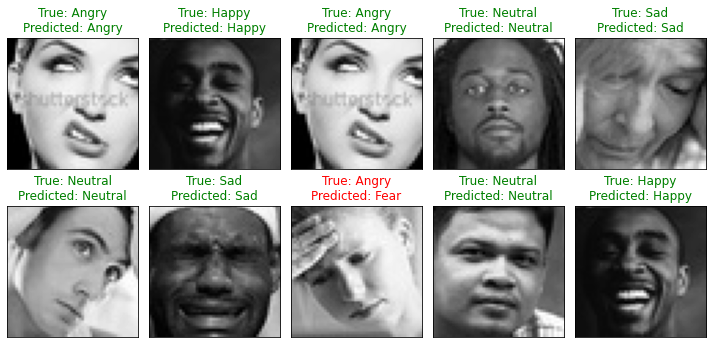

In [397]:
# Emotion classes for the dataset
Emotion_Classes = ['Angry', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Assuming test_generator and model are already defined
batch_size = test_generator.batch_size

# Selecting a random batch from the test generator
Random_batch = np.random.randint(0, len(test_generator) - 1)

# Selecting random image indices from the batch
Random_Img_Index = np.random.randint(0, batch_size, 10)

# Setting up the plot
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    # Fetching the random image and its label
    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]
    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]], axis=0)

    # Making a prediction using the model
    Model_Prediction = np.argmax(model.predict(tf.expand_dims(Random_Img, axis=0), verbose=0), axis=1)[0]

    # Displaying the image
    ax.imshow(Random_Img.squeeze(), cmap='gray')  # Assuming the images are grayscale
    # Setting the title with true and predicted labels, colored based on correctness
    color = "green" if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction] else "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()